# Chinchilla Scaling Laws - Code Demonstration
## Training Compute-Optimal Large Language Models

This notebook demonstrates the key scaling relationships discovered in the Chinchilla paper.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Dhesel28/-chinchilla-paper-presentation/blob/main/chinchilla_scaling_demo.ipynb)

In [ ]:
# Install required packages
!pip install numpy matplotlib scipy pandas seaborn

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
import pandas as pd

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

## 1. The Parametric Loss Function

Chinchilla models loss as:

$$L(N, D) = E + \frac{A}{N^\alpha} + \frac{B}{D^\beta}$$

Where:
- $N$ = number of parameters
- $D$ = number of training tokens
- $E$ = irreducible loss (entropy of natural text)
- $\alpha, \beta$ = scaling exponents

In [10]:
# Chinchilla's fitted parameters
E = 1.69
A = 406.4
B = 410.7
alpha = 0.34
beta = 0.28

def loss_function(N, D):
    """Compute predicted loss given model size N and training tokens D"""
    return E + A / (N ** alpha) + B / (D ** beta)

# Example: Compute loss for different model/data configurations
print("Loss predictions:")
print(f"Gopher (280B params, 300B tokens): {loss_function(280e9, 300e9):.4f}")
print(f"Chinchilla (70B params, 1.4T tokens): {loss_function(70e9, 1.4e12):.4f}")
print(f"GPT-3 (175B params, 300B tokens): {loss_function(175e9, 300e9):.4f}")

Loss predictions:
Gopher (280B params, 300B tokens): 1.9933
Chinchilla (70B params, 1.4T tokens): 1.9366
GPT-3 (175B params, 300B tokens): 2.0023


## 2. Optimal Scaling Relationships

For a given compute budget $C$, the optimal model size and training tokens are:

$$N_{opt} \propto C^{0.50}$$
$$D_{opt} \propto C^{0.49}$$

In [11]:
def compute_flops(N, D):
    """Approximate FLOPs for training (simplified)"""
    return 6 * N * D

def optimal_model_size(C, a=0.50, G=0.5):
    """Compute optimal model size for compute budget C"""
    return G * (C / 6) ** a

def optimal_tokens(C, b=0.49, H=2.0):
    """Compute optimal training tokens for compute budget C"""
    return H * (C / 6) ** b

# Generate compute budgets from 1e20 to 1e25 FLOPs
compute_budgets = np.logspace(20, 25, 50)

# Compute optimal allocations
optimal_params = [optimal_model_size(C) for C in compute_budgets]
optimal_data = [optimal_tokens(C) for C in compute_budgets]

# Create comparison dataframe
models_df = pd.DataFrame({
    'Model': ['GPT-3', 'Gopher', 'Chinchilla', 'MT-NLG'],
    'Parameters': [175e9, 280e9, 70e9, 530e9],
    'Tokens': [300e9, 300e9, 1.4e12, 270e9],
    'Compute': [175e9*300e9*6, 280e9*300e9*6, 70e9*1.4e12*6, 530e9*270e9*6]
})

print("\nExisting Large Models:")
print(models_df.to_string(index=False))


Existing Large Models:
     Model   Parameters       Tokens      Compute
     GPT-3 1.750000e+11 3.000000e+11 3.150000e+23
    Gopher 2.800000e+11 3.000000e+11 5.040000e+23
Chinchilla 7.000000e+10 1.400000e+12 5.880000e+23
    MT-NLG 5.300000e+11 2.700000e+11 8.586000e+23


## 3. Visualizing Chinchilla vs Kaplan Scaling

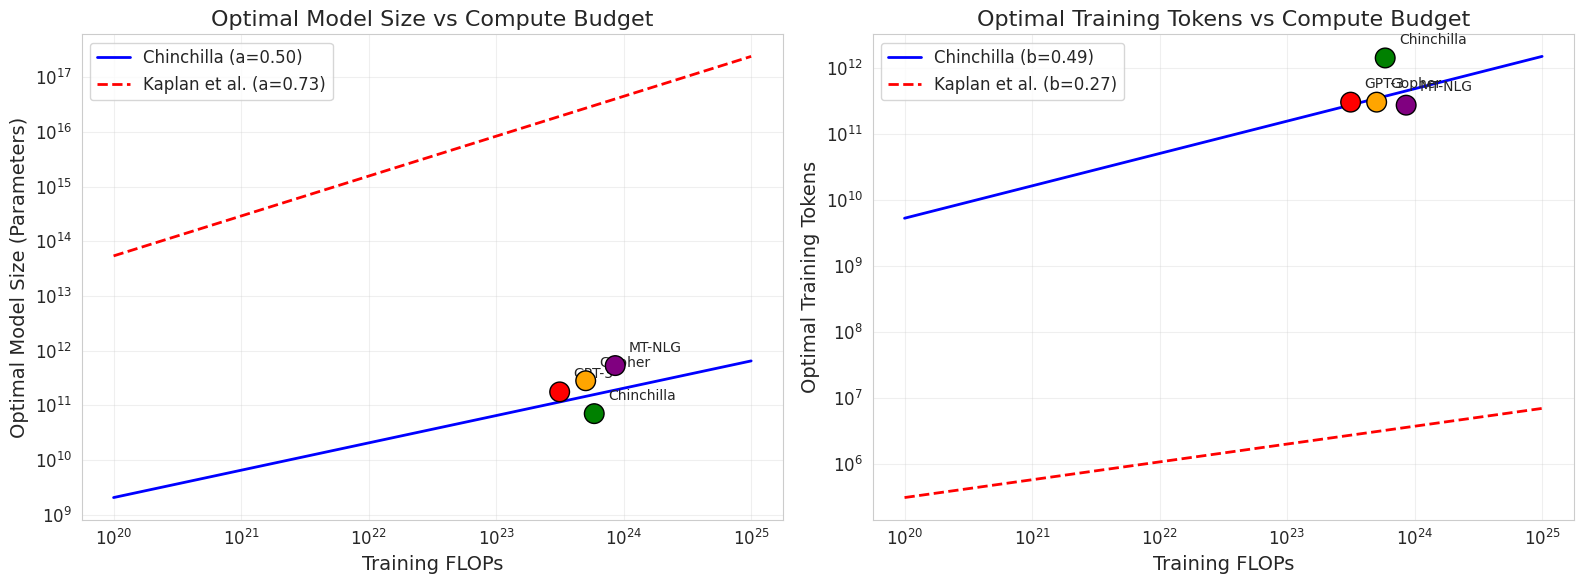


📊 Key Insight: Chinchilla predicts balanced scaling (50/50), while Kaplan heavily favored model size (73/27)


In [12]:
# Kaplan et al. (2020) scaling laws
def kaplan_model_size(C, a=0.73):
    return 0.5 * (C / 6) ** a

def kaplan_tokens(C, b=0.27):
    return 2.0 * (C / 6) ** b

# Compute Kaplan predictions
kaplan_params = [kaplan_model_size(C) for C in compute_budgets]
kaplan_data = [kaplan_tokens(C) for C in compute_budgets]

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Optimal Parameters vs Compute
ax1.loglog(compute_budgets, optimal_params, 'b-', linewidth=2, label='Chinchilla (a=0.50)')
ax1.loglog(compute_budgets, kaplan_params, 'r--', linewidth=2, label='Kaplan et al. (a=0.73)')

# Add existing models
ax1.scatter(models_df['Compute'], models_df['Parameters'],
           c=['red', 'orange', 'green', 'purple'], s=200, zorder=5, edgecolor='black')
for idx, row in models_df.iterrows():
    ax1.annotate(row['Model'], (row['Compute'], row['Parameters']),
                xytext=(10, 10), textcoords='offset points', fontsize=10)

ax1.set_xlabel('Training FLOPs', fontsize=14)
ax1.set_ylabel('Optimal Model Size (Parameters)', fontsize=14)
ax1.set_title('Optimal Model Size vs Compute Budget', fontsize=16)
ax1.legend(fontsize=12)
ax1.grid(True, alpha=0.3)

# Plot 2: Optimal Tokens vs Compute
ax2.loglog(compute_budgets, optimal_data, 'b-', linewidth=2, label='Chinchilla (b=0.49)')
ax2.loglog(compute_budgets, kaplan_data, 'r--', linewidth=2, label='Kaplan et al. (b=0.27)')

# Add existing models
ax2.scatter(models_df['Compute'], models_df['Tokens'],
           c=['red', 'orange', 'green', 'purple'], s=200, zorder=5, edgecolor='black')
for idx, row in models_df.iterrows():
    ax2.annotate(row['Model'], (row['Compute'], row['Tokens']),
                xytext=(10, 10), textcoords='offset points', fontsize=10)

ax2.set_xlabel('Training FLOPs', fontsize=14)
ax2.set_ylabel('Optimal Training Tokens', fontsize=14)
ax2.set_title('Optimal Training Tokens vs Compute Budget', fontsize=16)
ax2.legend(fontsize=12)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 Key Insight: Chinchilla predicts balanced scaling (50/50), while Kaplan heavily favored model size (73/27)")

## 4. Loss Contour Visualization

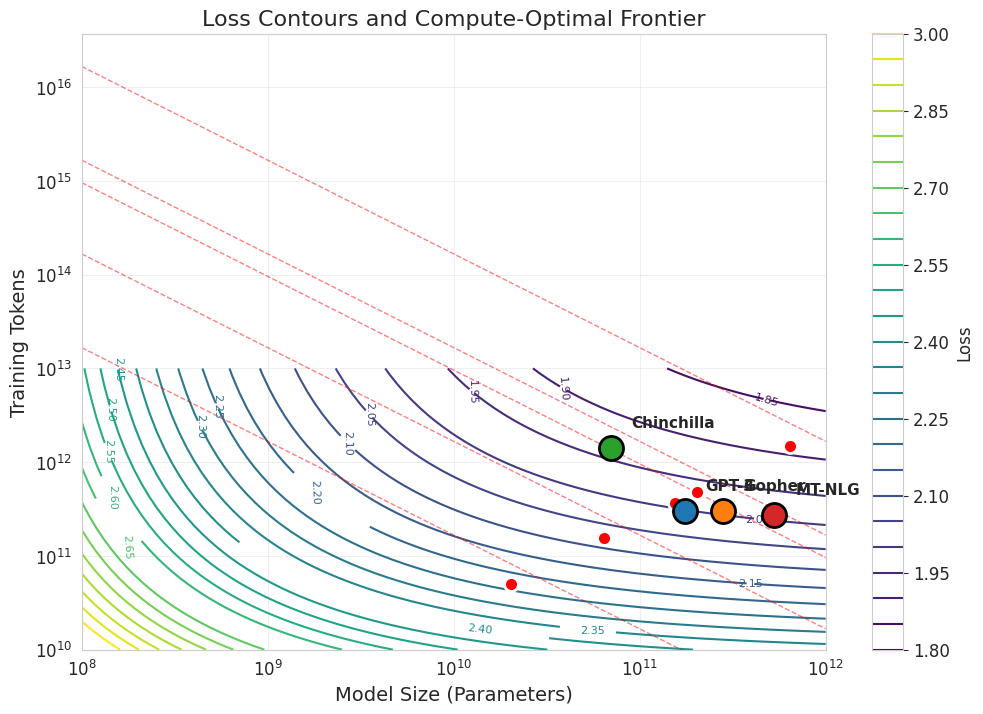


📊 Red dots show the compute-optimal frontier. Existing models are undertrained!


In [13]:
# Create a grid of model sizes and token counts
N_range = np.logspace(8, 12, 100)  # 100M to 1T parameters
D_range = np.logspace(10, 13, 100)  # 10B to 10T tokens
N_grid, D_grid = np.meshgrid(N_range, D_range)

# Compute loss for each point
L_grid = loss_function(N_grid, D_grid)

# Create figure
plt.figure(figsize=(12, 8))
levels = np.linspace(1.8, 3.0, 25)
contour = plt.contour(N_grid, D_grid, L_grid, levels=levels, cmap='viridis')
plt.clabel(contour, inline=True, fontsize=8, fmt='%.2f')

# Plot efficient frontier (iso-FLOP lines)
for C in [1e22, 1e23, 5.76e23, 1e24, 1e25]:
    N_opt = optimal_model_size(C)
    D_opt = optimal_tokens(C)
    plt.scatter([N_opt], [D_opt], c='red', s=100, zorder=5, edgecolor='white', linewidth=2)

    # Draw iso-FLOP line
    N_isoflop = np.logspace(8, 12, 50)
    D_isoflop = C / (6 * N_isoflop)
    plt.plot(N_isoflop, D_isoflop, 'r--', alpha=0.5, linewidth=1)

# Add existing models
for idx, row in models_df.iterrows():
    plt.scatter([row['Parameters']], [row['Tokens']],
               s=300, zorder=6, edgecolor='black', linewidth=2)
    plt.annotate(row['Model'], (row['Parameters'], row['Tokens']),
                xytext=(15, 15), textcoords='offset points', fontsize=11, fontweight='bold')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Model Size (Parameters)', fontsize=14)
plt.ylabel('Training Tokens', fontsize=14)
plt.title('Loss Contours and Compute-Optimal Frontier', fontsize=16)
plt.colorbar(contour, label='Loss')
plt.grid(True, alpha=0.3)
plt.show()

print("\n📊 Red dots show the compute-optimal frontier. Existing models are undertrained!")

## 5. Practical Calculator: Given Your Compute Budget

In [14]:
def recommend_model_config(compute_budget_flops):
    """
    Given a compute budget in FLOPs, recommend optimal model size and training tokens
    """
    N_opt = optimal_model_size(compute_budget_flops)
    D_opt = optimal_tokens(compute_budget_flops)
    predicted_loss = loss_function(N_opt, D_opt)

    print(f"="*60)
    print(f"Compute Budget: {compute_budget_flops:.2e} FLOPs")
    print(f"="*60)
    print(f"Optimal Model Size: {N_opt/1e9:.2f}B parameters")
    print(f"Optimal Training Tokens: {D_opt/1e9:.2f}B tokens")
    print(f"Predicted Loss: {predicted_loss:.4f}")
    print(f"="*60)

    # Compare to Kaplan
    N_kaplan = kaplan_model_size(compute_budget_flops)
    D_kaplan = kaplan_tokens(compute_budget_flops)

    print(f"\nKaplan et al. (2020) would recommend:")
    print(f"  Model Size: {N_kaplan/1e9:.2f}B parameters ({N_kaplan/N_opt:.2f}x larger)")
    print(f"  Training Tokens: {D_kaplan/1e9:.2f}B tokens ({D_opt/D_kaplan:.2f}x more data needed!)")

    return N_opt, D_opt

# Example: What if you have the same budget as Gopher?
gopher_compute = 5.76e23
recommend_model_config(gopher_compute)

print("\n" + "="*60)
print("TRY IT YOURSELF: Change the compute budget below!")
print("="*60)

# Interactive: Try different budgets
my_compute_budget = 1e24  # Change this value!
recommend_model_config(my_compute_budget)

Compute Budget: 5.76e+23 FLOPs
Optimal Model Size: 154.92B parameters
Optimal Training Tokens: 365.04B tokens
Predicted Loss: 1.9914

Kaplan et al. (2020) would recommend:
  Model Size: 29924575.92B parameters (193162.31x larger)
  Training Tokens: 0.00B tokens (113788.84x more data needed!)

TRY IT YOURSELF: Change the compute budget below!
Compute Budget: 1.00e+24 FLOPs
Optimal Model Size: 204.12B parameters
Optimal Training Tokens: 478.34B tokens
Predicted Loss: 1.9684

Kaplan et al. (2020) would recommend:
  Model Size: 44763041.89B parameters (219293.22x larger)
  Training Tokens: 0.00B tokens (128471.48x more data needed!)


(204124145231.93152, 478339101004.36536)

## 6. Token-to-Parameter Ratio Analysis


Token-to-Parameter Ratio Comparison:
        Model  Parameters (B)  Tokens (B)  Token:Param Ratio Chinchilla Optimal?
        GPT-3             175         300           1.714286      ✗ Undertrained
       Gopher             280         300           1.071429      ✗ Undertrained
   Chinchilla              70        1400          20.000000           ✓ Optimal
LLaMA-1 (65B)              65        1400          21.538462           ✓ Optimal
LLaMA-2 (70B)              70        2000          28.571429       ⚠ Overtrained
 LLaMA-3 (8B)               8       15000        1875.000000       ⚠ Overtrained


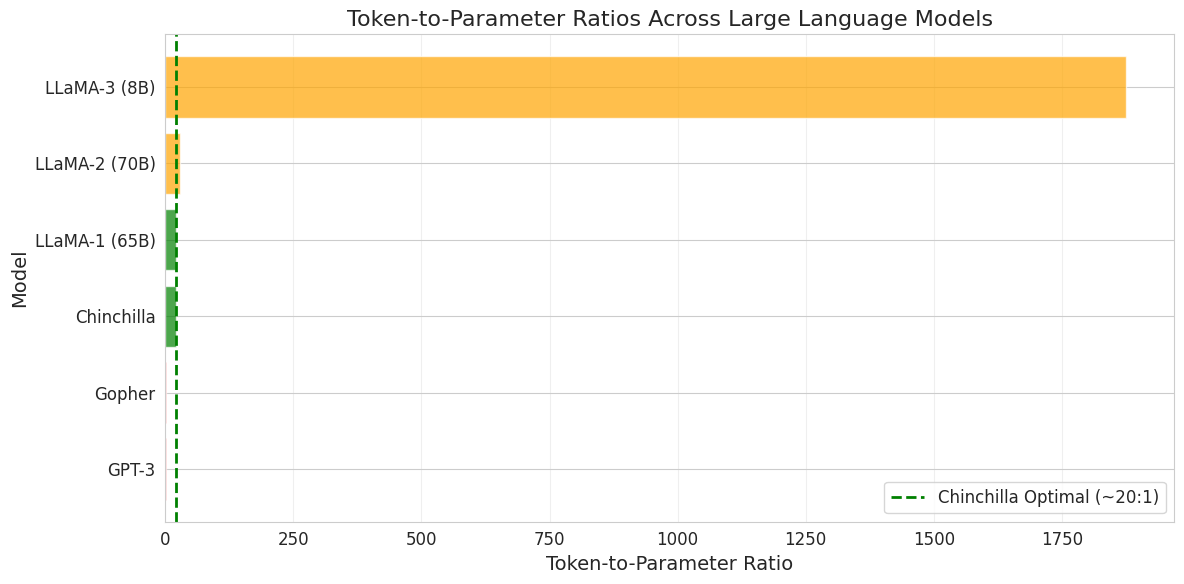

In [15]:
# Compare token-to-parameter ratios
models_comparison = pd.DataFrame({
    'Model': ['GPT-3', 'Gopher', 'Chinchilla', 'LLaMA-1 (65B)', 'LLaMA-2 (70B)', 'LLaMA-3 (8B)'],
    'Parameters (B)': [175, 280, 70, 65, 70, 8],
    'Tokens (B)': [300, 300, 1400, 1400, 2000, 15000],
})

models_comparison['Token:Param Ratio'] = models_comparison['Tokens (B)'] / models_comparison['Parameters (B)']
models_comparison['Chinchilla Optimal?'] = models_comparison['Token:Param Ratio'].apply(
    lambda x: '✓ Optimal' if 15 <= x <= 25 else ('⚠ Overtrained' if x > 25 else '✗ Undertrained')
)

print("\nToken-to-Parameter Ratio Comparison:")
print(models_comparison.to_string(index=False))

# Visualize
plt.figure(figsize=(12, 6))
colors = ['red' if '✗' in status else 'orange' if '⚠' in status else 'green'
          for status in models_comparison['Chinchilla Optimal?']]

plt.barh(models_comparison['Model'], models_comparison['Token:Param Ratio'], color=colors, alpha=0.7)
plt.axvline(x=20, color='green', linestyle='--', linewidth=2, label='Chinchilla Optimal (~20:1)')
plt.xlabel('Token-to-Parameter Ratio', fontsize=14)
plt.ylabel('Model', fontsize=14)
plt.title('Token-to-Parameter Ratios Across Large Language Models', fontsize=16)
plt.legend(fontsize=12)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

## 7. Key Takeaways

### The Chinchilla Scaling Law:
1. **Equal scaling**: For every doubling of compute, double BOTH model size and training tokens
2. **Previous models were undertrained**: GPT-3, Gopher, etc. used ~4× too many parameters and ~4× too little data
3. **Practical impact**:
   - Same compute budget → Better performance with smaller, longer-trained models
   - 4× reduction in inference costs
   - Much more emphasis on data quality and quantity

### Implications:
- **Training**: Spend more time collecting and curating data
- **Deployment**: Smaller models are cheaper to serve
- **Research**: Data scaling is as important as model scaling